## In questo file andiamo ad applicare algoritmi di clustering dopo aver eliminato eventuali duplicati ed aver ridotto le dimensioni del dataset con undersampling. Prima di applicare gli algoritmi di clustering, applichiamo la pca che ci permette di selezionare le feature più rilevanti

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from matplotlib.lines import Line2D
import os
from sklearn_som.som import SOM

In [2]:
nome_file='Wednesday-14-02-2018_TrafficForML_CICFlowMeter'

with open('pickle/'+nome_file+'/scaled_document.pickle', 'rb') as handle:

    df = pickle.load(handle)

In [3]:
# Seleziona una frazione casuale delle righe in base a una colonna specifica
# Selezioniamo il 50% delle righe

colonna_interessata = 'Label'
frazione_da_selezionare = 0.2  # Ad esempio, seleziona il 50% delle righe


df = df.groupby(colonna_interessata).apply(lambda x: x.sample(frac=frazione_da_selezionare, random_state=42)).reset_index(drop=True)

In [4]:
#contiamo il numero di feature per label

df_prova = df.groupby(['Label'])['Label'].count()

df_prova=df_prova.to_frame()
print(df_prova)
df_prova.set_index('Label')
df_prova=df_prova.rename(columns={'Label':'Count'})

        Label
Label        
0      132762
1       38671
2       37518


In [5]:
#creiamo un array in cui andiamo a mettere le 5 feature più importanti per filtrare poi il dataframe

import csv

results = []
with open('top_feature/'+ nome_file +'/top5.csv', newline='') as inputfile:
    for row in csv.reader(inputfile):
        results.append(row[0])

results.pop(0)
print(results)

['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Init Fwd Win Byts', 'PSH Flag Cnt']


In [6]:
#otteniamo il dataframe con solo le 5 feature più importanti

df_filtrato = pd.DataFrame()
for a in df.head(0):
    if a in results:
        df_filtrato[a] = df[a]

df_filtrato['Label'] = df['Label']
display(df_filtrato)

,Flow Pkts/s,Bwd Pkts/s,PSH Flag Cnt,Init Fwd Win Byts,Fwd Seg Size Min,Label
0,0.014706,0.000000,0.0,0.980240,0.416667,0
1,0.000002,0.000002,1.0,0.125015,0.416667,0
2,0.027778,0.027778,0.0,0.014511,0.416667,0
3,0.000381,0.000381,0.0,0.000000,0.166667,0
4,0.002818,0.003221,1.0,0.125015,0.416667,0
...,...,...,...,...,...,...
208946,0.000026,0.000025,1.0,0.410217,0.666667,2
208947,0.083333,0.083333,0.0,0.003693,0.666667,2
208948,0.000029,0.000029,1.0,0.410217,0.666667,2
208949,0.062500,0.062500,0.0,0.003693,0.666667,2


In [7]:
ssh_br_force = df_filtrato[df_filtrato.Label == 2]
ftp_br_force = df_filtrato[df_filtrato.Label == 1]
benign = df_filtrato[df_filtrato.Label == 0]

print("Benign: ", len(benign), "FTP - BruteForce: ", len(ftp_br_force), "SSH - BruteForce: ", len(ssh_br_force))

Benign:  132762 FTP - BruteForce:  38671 SSH - BruteForce:  37518


In [8]:
#bilanciamento del dataset
balanced_d = pd.concat([ssh_br_force, benign.sample(len(ssh_br_force)), ftp_br_force.sample(len(ssh_br_force))])
bal_x = balanced_d.iloc[:,:-1]
bal_y = balanced_d.iloc[:,-1:]
balanced_d.shape

(112554, 6)

## Applicazione della PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver="auto").fit(bal_x)
pca_x = pca.transform(bal_x)

In [10]:
n_clusters = len(balanced_d['Label'].unique())  # numero di cluster

In [11]:
#applicazione del kmeans
km = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_pred = km.fit_predict(pca_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[y_pred == i]
    cluster_classes = bal_y[y_pred == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [12]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [13]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_pred))
    if y_pred[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_pred[a] = true_value

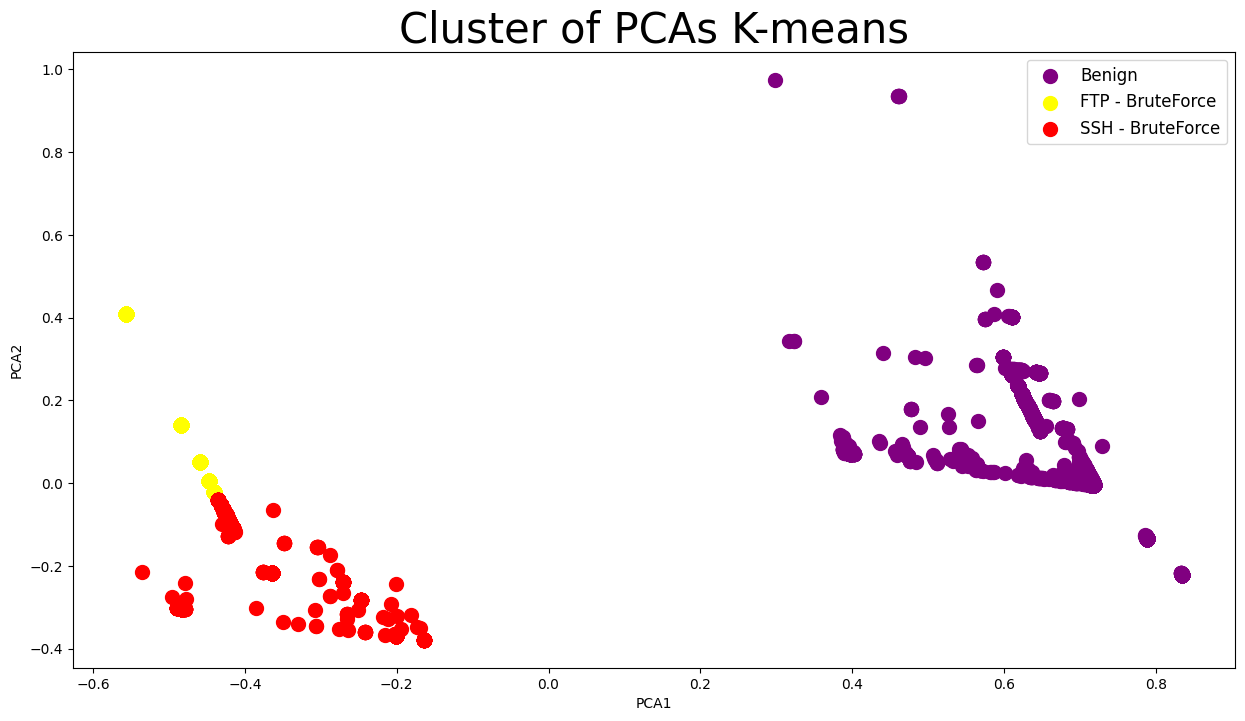

In [14]:
#Plot dei risultati

plt.figure(figsize=(15,8))
plt.title('Cluster of PCAs K-means', fontsize = 30)

plt.scatter(pca_x[y_pred == 0, 0], pca_x[y_pred == 0, 1], s = 100, c = 'purple', label = "Benign")
plt.scatter(pca_x[y_pred == 1, 0], pca_x[y_pred == 1, 1], s = 100, c = 'yellow', label = "FTP - BruteForce")
plt.scatter(pca_x[y_pred == 2, 0], pca_x[y_pred == 2, 1], s = 100, c = 'red', label = "SSH - BruteForce")

plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large')

title = "KMeans_PCA"
if not os.path.exists('image/'+nome_file+'/clustering_pca/'):
    os.makedirs('image/'+nome_file+'/clustering_pca/')
plt.savefig('image/'+nome_file+'/clustering_pca/'+ title +'.png')

plt.show()

In [15]:
accuracy_kmeans = str(accuracy_score(y_pred,bal_y))
precision_kmeans = str(precision_score(y_pred,bal_y,average='weighted'))
recall_kmeans = str(recall_score(y_pred,bal_y,average='weighted'))

# accuratezza kmeans
print("accuratezza " + accuracy_kmeans)
# precision kmeans
print("precision " + precision_kmeans)
# recall kemans
print("recall " + recall_kmeans)


metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_kmeans,precision_kmeans,recall_kmeans]
})

if not os.path.exists('metriche/'+nome_file +'/clustering_pca/'):
    os.makedirs('metriche/'+nome_file +'/clustering_pca/')

metriche.to_csv('metriche/'+nome_file +'/clustering_pca'+'/metriche_kmeans_pca.csv',index=False)

accuratezza 0.6594168132629671
precision 0.647526269443134
recall 0.6594168132629671


In [16]:
#clustering gerarchico

hc = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(pca_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[y_hc == i]
    cluster_classes = bal_y[y_hc == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [17]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [18]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_hc))
    if y_hc[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_hc[a] = true_value

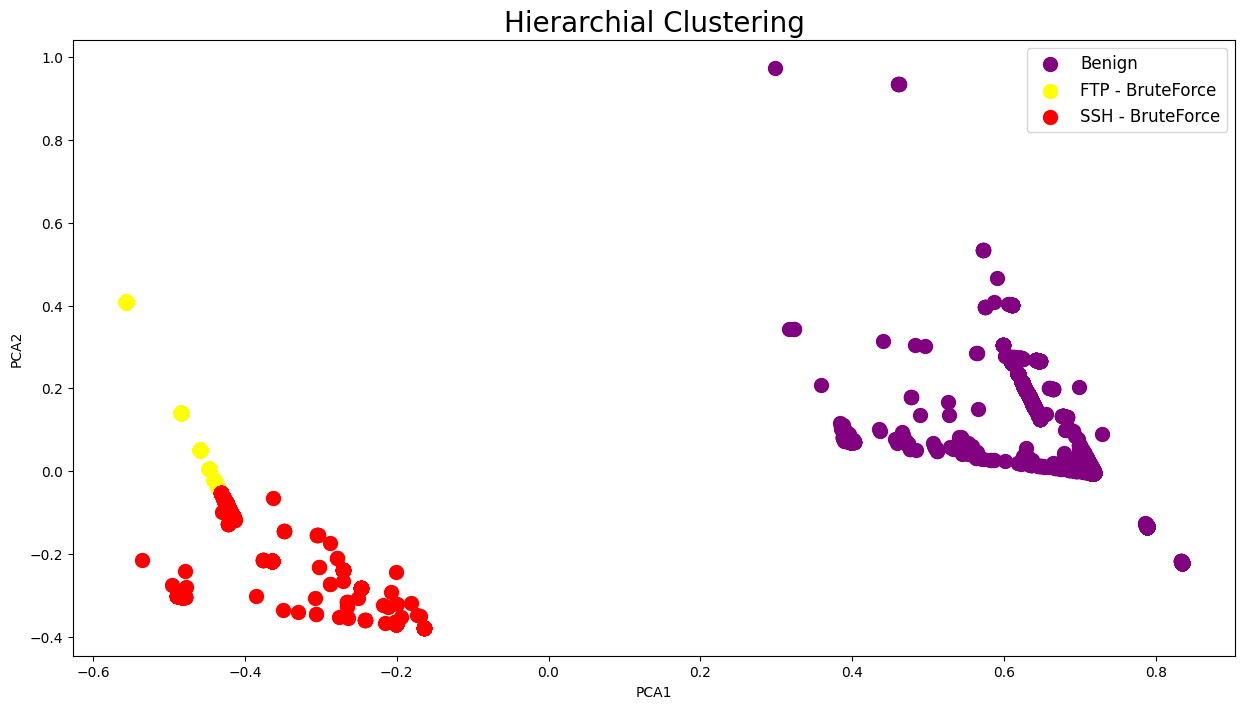

In [19]:
plt.figure(figsize=(15,8))

plt.scatter(pca_x[y_hc == 0, 0], pca_x[y_hc == 0, 1], s = 100, c = 'purple', label = "Benign")
plt.scatter(pca_x[y_hc == 1, 0], pca_x[y_hc == 1, 1], s = 100, c = 'yellow', label = "FTP - BruteForce")
plt.scatter(pca_x[y_hc == 2, 0], pca_x[y_hc == 2, 1], s = 100, c = 'red', label = "SSH - BruteForce")

plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large')

title = ("Clust_gerarchico_PCA")
if not os.path.exists('image/'+nome_file+'/clustering_pca/'):
    os.makedirs('image/'+nome_file+'/clustering_pca/')
plt.savefig('image/'+nome_file+'/clustering_pca/'+ title +'.png')

plt.show()

In [20]:
accuracy_gerarchico = str(accuracy_score(y_hc,bal_y))
precision_gerarchico = str(precision_score(y_hc,bal_y,average='weighted'))
recall_gerarchico = str(recall_score(y_hc,bal_y,average='weighted'))

# accuratezza gerarchico
print("accuratezza" + accuracy_gerarchico)
# precision gerarchico
print("precision" + precision_gerarchico)
# recall gerarchico
print("recall" + recall_gerarchico)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_gerarchico,precision_gerarchico,recall_gerarchico]
})

if not os.path.exists('metriche/'+nome_file +'/clustering_pca/'):
    os.makedirs('metriche/'+nome_file +'/clustering_pca/')

metriche.to_csv('metriche/'+nome_file +'/clustering_pca'+'/metriche_gerarchico_PCA.csv',index=False)

accuratezza0.6601098139559678
precision0.6483992899867126
recall0.6601098139559678


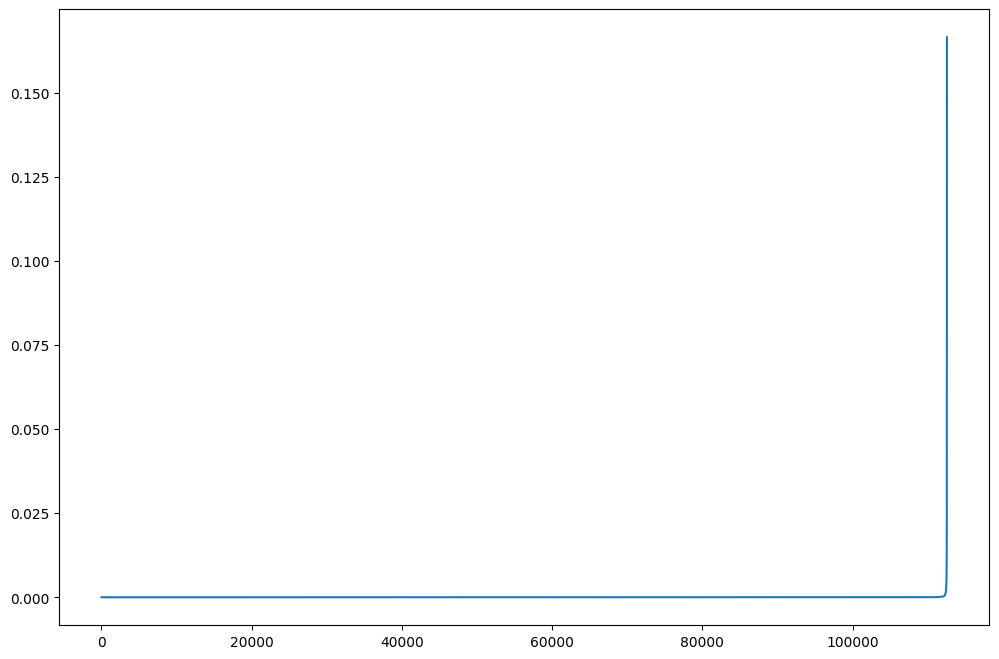

In [21]:
#individuazione eps

from sklearn.neighbors import NearestNeighbors
import numpy as np
import random

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(pca_x)
distances, indices = nbrs.kneighbors(pca_x)

distances = np.sort(distances, axis=0)
plt.figure(figsize=(12,8))
plt.plot(distances[:,1])

In [22]:
#applicazione DBSCAN

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.01, min_samples=6).fit(pca_x)
y_scan = db.labels_
y_scan

array([0, 0, 1, ..., 8, 8, 8])

In [23]:
# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[y_scan == i]
    cluster_classes = bal_y[y_scan == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [24]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [25]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_scan))
    if y_scan[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_scan[a] = true_value

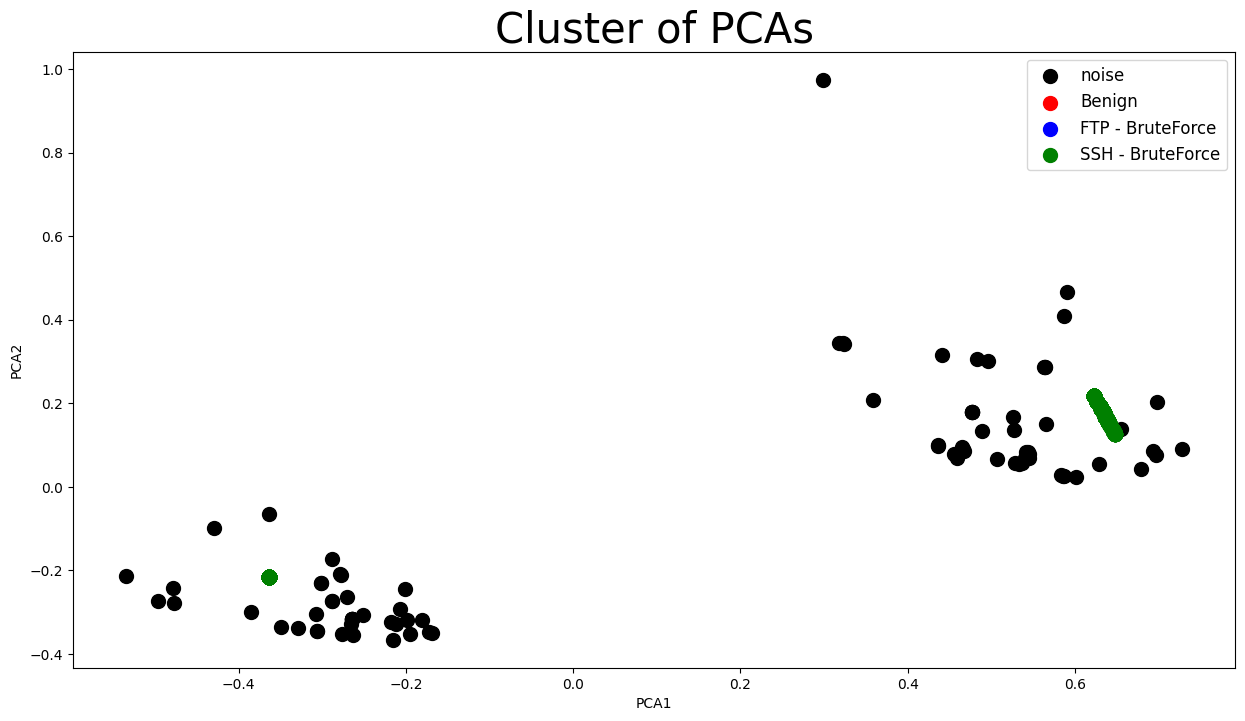

In [26]:
plt.figure(figsize=(15,8))
plt.title('Cluster of PCAs', fontsize = 30)

plt.scatter(pca_x[y_scan == -1, 0], pca_x[y_scan == -1, 1], s = 100, c = 'black', label = "noise")
plt.scatter(pca_x[y_scan == 0, 0], pca_x[y_scan == 0, 1], s = 100, c = 'red', label = "Benign")
plt.scatter(pca_x[y_scan == 1, 0], pca_x[y_scan == 1, 1], s = 100, c = 'blue', label = "FTP - BruteForce")
plt.scatter(pca_x[y_scan == 2, 0], pca_x[y_scan == 2, 1], s = 100, c = 'green', label = "SSH - BruteForce")

plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large')

title = ("DB_Scan_PCA")
feature_name = title.replace('/','_')
if not os.path.exists('image/'+nome_file+'/clustering_pca/'):
    os.makedirs('image/'+nome_file+'/clustering_pca/')
plt.savefig('image/'+nome_file+'/clustering_pca/'+ title +'.png')

plt.show()

In [27]:
accuracy_dbscan = str(accuracy_score(y_scan,bal_y))
precision_dbscan = str(precision_score(y_scan,bal_y,average='weighted'))
recall_dbscan = str(recall_score(y_scan,bal_y,average='weighted'))

# accuratezza dbscan
print("accuratezza" + accuracy_dbscan)
# precision dbscan
print("precision" + precision_dbscan)
# recall dbscan
print("recall" + recall_dbscan)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_dbscan,precision_dbscan,recall_dbscan]
})

if not os.path.exists('metriche/'+nome_file +'/clustering_pca/'):
    os.makedirs('metriche/'+nome_file +'/clustering_pca/')

metriche.to_csv('metriche/'+nome_file +'/clustering_pca'+'/metriche_dbscan_PCA.csv',index=False)

accuratezza0.3124278124278124
precision0.29321647484929114
recall0.3124278124278124


/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Eseguiamo il clustering

n_clusters = len(balanced_d['Label'].unique())  # numero di cluster

y_som = SOM(m=3, n=1, dim=2)

y_som.fit(pca_x)

predictions = y_som.predict(pca_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[predictions == i]
    cluster_classes = bal_y[predictions == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [12]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe

for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [13]:
indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(predictions))
    if predictions[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        predictions[a] = true_value

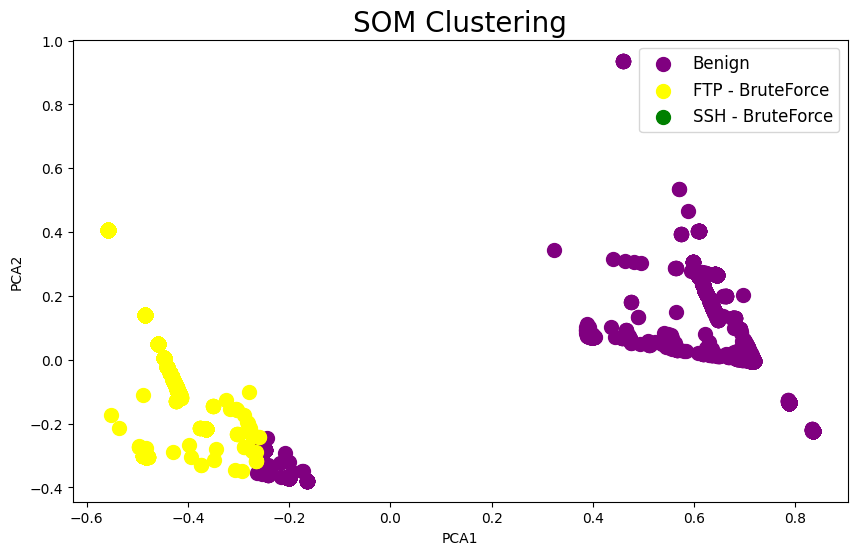

In [14]:
# Plot dei risultati
plt.figure(figsize=(10,6))

plt.scatter(pca_x[predictions == 0, 0], pca_x[predictions == 0, 1], s = 100, c = 'purple', label = "Benign")
plt.scatter(pca_x[predictions == 1, 0], pca_x[predictions == 1, 1], s = 100, c = 'yellow', label = "FTP - BruteForce")
plt.scatter(pca_x[predictions == 2, 0], pca_x[predictions == 2, 1], s = 100, c = 'green', label = "SSH - BruteForce")

plt.title('SOM Clustering', fontsize = 20)
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large')

title = ("SOM_PCA")
if not os.path.exists('image/'+nome_file+'/clustering_pca/'):
    os.makedirs('image/'+nome_file+'/clustering_pca/')
plt.savefig('image/'+nome_file+'/clustering_pca/'+ title +'.png')

plt.show()

In [15]:
accuracy_som = str(accuracy_score(predictions,bal_y))
precision_som = str(precision_score(predictions,bal_y,average='weighted'))
recall_som = str(recall_score(predictions,bal_y,average='weighted'))

# accuratezza gerarchico
print("accuratezza " + accuracy_som)
# precision gerarchico
print("precision " + precision_som)
# recall gerarchico
print("recall " + recall_som)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_som,precision_som,recall_som]
})

if not os.path.exists('metriche/'+nome_file+ '/clustering_pca/'):
    os.makedirs('metriche/'+nome_file+ '/clustering_pca/')

metriche.to_csv('metriche/'+nome_file+ '/clustering_pca' + '/metriche_som.csv',index=False)

accuratezza 0.6617712386943156
precision 0.9927228819914177
recall 0.6617712386943156


/home/spalazzi/anaconda3/envs/cyber/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
